# Calculate/convert required variables for daily and hourly TMY

### Variables in output files:

#### Daily:
- Max dry bulb temperature
- Min dry bulb temperature
- Mean dry bulb temperature
- Max dew point temperature
- Min dew point temperature
- Mean dew point temperature
- Max wind speed
- Mean wind speed
- Global solar irradiance
- Direct solar irradiance

#### Hourly:
- Dry bulb temperature
- Wet bulb temperature
- Absolute moisture content
- Atmospheric pressure
- Wind speed
- Wind direction
- Global solar irradiance
- Direct solar irradiance
- Diffuse solar irradiance

Using Rob Warren's atmos package (https://github.com/robwarrenwx/atmos/tree/main) to calculate humidity-based variables (dew point, wet bulb temperature, specific humidity). Ref: Warren, R.A. (2025) A consistent treatment of mixed-phase saturation for atmospheric thermodynamics. Quarterly Journal of the Royal Meteorological Society, 151:e4866. Available from: https://doi.org/10.1002/qj.4866


In [1]:
import xarray as xr
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/home/565/dh4185/mn51-dh4185/repos_collab/atmos/')
from atmos.thermo import dewpoint_temperature
from atmos.thermo import wet_bulb_temperature


In [3]:
daily_vars = {
    "Max_dry_bulb_temperature":{"fin_unit":"degC"},
    "Min_dry_bulb_temperature":{"fin_unit":"degC"},
    "Mean_dry_bulb_temperature":{"fin_unit":"degC"},
    "Max_dewpoint_temperature":{"fin_unit":"degC"},
    "Min_dewpoint_temperature":{"fin_unit":"degC"},
    "Mean_dewpoint_temperature":{"fin_unit":"degC"},
    "Max_wind_speed":{"fin_unit":"m/s"},
    "Mean_wind_speed":{"fin_unit":"m/s"},
    "Global_solar_irradiance":{"fin_unit":"W/m2"},
    "Direct_solar_irradiance":{"fin_unit":"W/m2"}
    }

hourly_vars = {
    "Dry_bulb_temperature":{"fin_unit":"degC"},
    "Wet_bulb_temperature":{"fin_unit":"degC"},
    "Absolute_moisture_content":{"fin_unit":"g/kg"},
    "Atmospheric_pressure":{"fin_unit":"kPa"},
    "Wind_speed":{"fin_unit":"m/s"},
    "Wind_direction":{"fin_unit":'sixteenth'},
    "Global_solar_irradiance":{"fin_unit":"W/m2"},
    "Direct solar irradiance":{"fin_unit":"W/m2"},
    "Diffuse solar irradiance":{"fin_unit":"W/m2"}
    }


In [4]:
# Functions
#< Keep attributes from input datasets
xr.set_options(keep_attrs = True)

def convert_temp_unit(da):
    if da.attrs['units'] not in ('degC', 'K'):
        raise ValueError("The 'unit' argument for tasmax and tasmin is neither 'C' (Celsius) or 'K' (Kelvin).")
    if da.attrs['units'] == 'K':
        da = da - 273.16
        da.attrs['units'] = 'degC'
    return da

def meanVar(varmax,varmin):        
    return (varmax + varmin) / 2.

In [5]:
input_dir = "/g/data/eg3/nesp_bff/step2_qdc_scaling/BARPA-R/"
ds_day = xr.open_dataset(f"{input_dir}Melbourne_AUS-15_CESM2_ssp370_r11i1p1f1_BOM_BARPA-R_v1-r1_day_2050_QDC-BARRAR2.nc")
ds_1hr = xr.open_dataset(f"{input_dir}Melbourne_AUS-15_CESM2_ssp370_r11i1p1f1_BOM_BARPA-R_v1-r1_1hr_2050_QDC-BARRAR2.nc")

## Daily data
Converting and calculating daily data for:
- Max dry bulb temperature
- Min dry bulb temperature
- Mean dry bulb temperature
- Max dew point temperature
- Min dew point temperature
- Mean dew point temperature
- Max wind speed
- Mean wind speed
- Global solar irradiance
- Direct solar irradiance

#### Dry bulb temperature (max/min/mean)

In [6]:
da_tasmax_fin = convert_temp_unit(ds_day['tasmax']).rename('Max_dry_bulb_temperature')
da_tasmin_fin = convert_temp_unit(ds_day['tasmin']).rename('Min_dry_bulb_temperature')
da_tasmean_fin = meanVar(da_tasmax_fin,da_tasmin_fin).rename('Mean_dry_bulb_temperature')

#### Dew point temperature (max/min/mean)

In [7]:
da_dewmax = dewpoint_temperature(ds_day['psl'], ds_day['tasmax'], ds_day['hussmax'])
da_dewmax.attrs['units'] = 'K'
da_dewmax_fin = convert_temp_unit(da_dewmax).rename('Max_dewpoint_temperature')

da_dewmin = dewpoint_temperature(ds_day['psl'], ds_day['tasmin'], ds_day['hussmin'])
da_dewmin.attrs['units'] = 'K'
da_dewmin_fin = convert_temp_unit(da_dewmin).rename('Min_dewpoint_temperature')

da_dewmean_fin = meanVar(da_dewmax_fin,da_dewmin_fin).rename('Mean_dewpoint_temperature')

#### Wind speed

In [8]:
da_sfcWind_fin = ds_day['sfcWind'].rename('Mean_wind_speed')
da_sfcWindmax_fin = ds_day['sfcWindmax'].rename('Max_wind_speed')

#### Radiation

In [9]:
da_rsds_fin = ds_day['rsds'].rename('Global_solar_irradiance')
da_rsdsdir_fin = ds_day['rsdsdir'].rename('Direct_solar_irradiance')

In [10]:
ds_fin = xr.merge([da_tasmax_fin, da_tasmin_fin, da_tasmean_fin,    # temperature components
                  da_dewmax_fin, da_dewmin_fin, da_dewmean_fin,     # moisture components
                  da_sfcWind_fin, da_sfcWindmax_fin,                # wind components
                  da_rsds_fin, da_rsdsdir_fin])                     # radiation components
ds_fin

<xarray.Dataset> Size: 964kB
Dimensions:                    (time: 10957)
Coordinates:
  * time                       (time) datetime64[ns] 88kB 1985-01-01 ... 2014...
    lat                        float64 8B -37.62
    lon                        float64 8B 144.8
    crs                        int32 4B 0
Data variables:
    Max_dry_bulb_temperature   (time) float64 88kB 26.68 24.0 ... 24.7 25.67
    Min_dry_bulb_temperature   (time) float64 88kB 15.79 14.65 ... 11.83 11.47
    Mean_dry_bulb_temperature  (time) float64 88kB 21.24 19.32 ... 18.27 18.57
    Max_dewpoint_temperature   (time) float64 88kB 15.02 14.83 ... 10.41 12.29
    Min_dewpoint_temperature   (time) float64 88kB 9.928 12.57 ... 3.969 8.352
    Mean_dewpoint_temperature  (time) float64 88kB 12.47 13.7 ... 7.191 10.32
    Mean_wind_speed            (time) float64 88kB ...
    Max_wind_speed             (time) float64 88kB ...
    Global_solar_irradiance    (time) float64 88kB ...
    Direct_solar_irradiance    (time) float64 88kB ...
Attributes:
    long_name:        Daily Maximum Near-Surface Air Temperature
    standard_name:    air_temperature
    cell_methods:     time: maximum (interval: 1 hour) time: maximum (interva...
    units:            degC
    grid_mapping:     crs
    history:          [2025-07-09 12:49:05] : Bias-adjusted with QuantileDelt...
    bias_adjustment:  QuantileDeltaMapping(group=Grouper(name='time.month'), ...

## Hourly data
Converting and calculating hourly data for:
- Dry bulb temperature
- Wet bulb temperature
- Absolute moisture content
- Atmospheric pressure
- Wind speed
- Wind direction
- Global solar irradiance
- Direct solar irradiance
- Diffuse solar irradiance

#### Temperature

In [59]:
da_tas_fin = convert_temp_unit(ds_1hr['tas']).rename('Dry_bulb_temperature')

#### Moisture
WET BULB TEMPERATURE CALCULATION NEEDS TO BE UPDATED WHEN ATMOS CODE IS UPDATED. PERS COMMS WITH ROB WARREN AND CASS ROGERS ON 28 JULY.

In [71]:
# Wet bulb temoerature using isobaric method which is similar but not identical to temperature read from a wet bulb thermometer. See: https://github.com/robwarrenwx/atmos/blob/main/README.md 
da_twbt = wet_bulb_temperature(ds_1hr['psl'],
                               ds_1hr['tas'],
                               ds_1hr['huss'],
                               saturation='isobaric', phase='liquid', polynomial=True)
da_twbt_fin = convert_temp_unit(da_twbt).rename('Wet_bulb_temperature')

da_huss_fin = (ds_1hr['huss']*1000).rename('Absolute_moisture_content')
da_huss_fin.attrs['units'] = 'g/kg'

#### Atmospheric pressure

In [67]:
da_psl_fin = (ds_1hr['psl']/1000).rename('Atmospheric_pressure')
da_psl_fin.attrs['units'] = 'kPa'

#### Wind Speed
Wind speed split into 16th. 0-16, 0=calm, 1=NNE, 16=N 

In [11]:
da_wind_speed = ds_1hr['uas'].rename('Wind_speed')


wind_dir_degrees = np.degrees(np.arctan2(ds_1hr['uas'], ds_1hr['vas'])) % 360


In [16]:
# da_compass = (((da_wind_dir/22.5)+0.5).astype('int') % 16).rename('degrees')
compass_points = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
                  "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
sixteenth = ["1", "2", "3", "4", "5", "6", "7", "8",
            "9", "10", "11", "12", "13", "14", "15", "16"]
# da = da_compass[compass_points]

# Calculate the index for the compass points/sixteenth
# Add 11.25 to shift the bins so N (0 degrees) is centered in its bin
# and then divide by 22.5 (degrees per point)
# The result is floored to get the integer index
index = ((wind_dir_degrees + 11.25) % 360) / 22.5
bin_index = index.astype(int)

wind_dir_sixteenth = bin_index.astype(str) # Convert to string type for mapping
wind_dir_sixteenth = wind_dir_sixteenth.where(wind_dir_sixteenth.notnull(), other=np.nan) # Handle NaNs if present

# Apply the mapping using a vectorized operation (or apply_ufunc for more complex cases)
# This example uses a direct lookup for simplicity, assuming the index is valid
wind_dir_sixteenth_mapped = xr.apply_ufunc(
    lambda x: np.array(sixteenth)[x],
    bin_index,
    vectorize=True,
    # dask="parallelized", # Use if working with dask-backed xarray objects
    output_dtypes=[str]
)
wind_dir_sixteenth_mapped_0 = wind_dir_sixteenth_mapped.where(da_wind_speed>=(1000/3600),wind_dir_sixteenth_mapped,0)# Mask where wind speed is <1kph
wind_dir_sixteenth_mapped_0

<xarray.DataArray 'uas' (time: 262968)> Size: 2MB
array(['16', '1', '1', ..., '8', '3', '2'], dtype='<U2')
Coordinates:
  * time     (time) datetime64[ns] 2MB 1985-01-01 ... 2014-12-31T23:00:00
    lat      float64 8B -37.62
    lon      float64 8B 144.8
    crs      int32 4B 0
Attributes:
    long_name:        Eastward Near-Surface Wind
    standard_name:    eastward_wind
    cell_methods:     time: point (interval: 1H) area: interpolation (method:...
    units:            m s-1
    grid_mapping:     crs
    history:          [2025-07-17 12:30:03] : Bias-adjusted with QuantileDelt...
    bias_adjustment:  QuantileDeltaMapping(group=Grouper(name='time.month'), ...

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


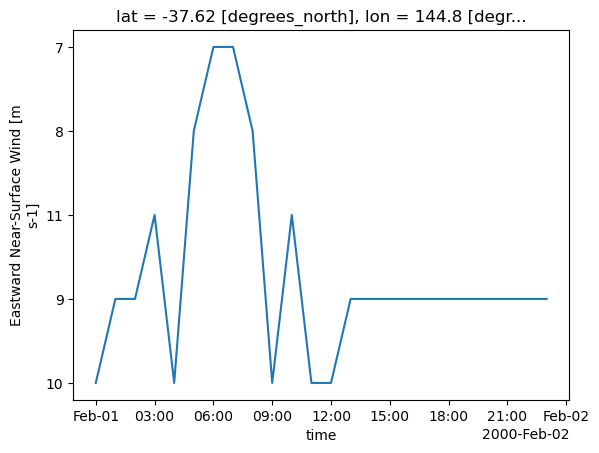

In [17]:
wind_dir_sixteenth_mapped_0.sel(time="2000-02-01").plot()

In [63]:
ds_1hr

<xarray.Dataset> Size: 23MB
Dimensions:  (time: 262968)
Coordinates:
  * time     (time) datetime64[ns] 2MB 1985-01-01 ... 2014-12-31T23:00:00
    lat      float64 8B ...
    lon      float64 8B ...
    crs      int32 4B ...
Data variables:
    tas      (time) float64 2MB ...
    hurs     (time) float64 2MB ...
    huss     (time) float64 2MB ...
    sfcWind  (time) float64 2MB ...
    psl      (time) float64 2MB ...
    uas      (time) float64 2MB ...
    vas      (time) float64 2MB ...
    clt      (time) float64 2MB ...
    rsds     (time) float64 2MB ...
    rsdsdir  (time) float64 2MB ...

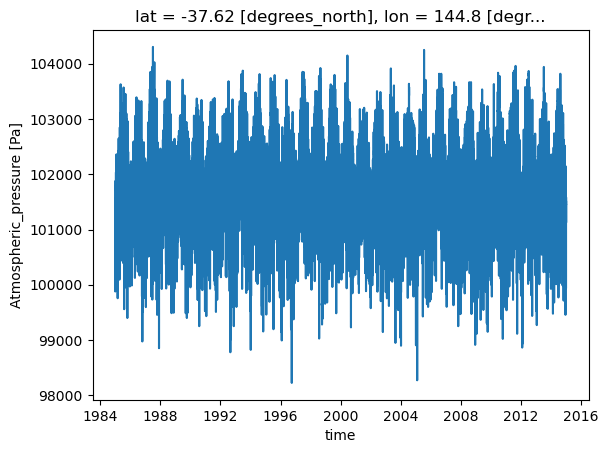

In [70]:
(da_psl_fin*1000).plot()